In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'

import load_nmeg as ld
import transform_nmeg as tr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Read Laura's data in

path = "/home/greg/Desktop/FINAL_DATABASIS/"
pjc_laura = pd.read_csv( path + "PJC_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_laura = pd.read_csv( path + "PJG_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')
pjc_lauraftp = pd.read_csv( path + "PJC_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_lauraftp = pd.read_csv( path + "PJG_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')

In [23]:
sum(pjg_laura.ET==pjg_lauraftp.ET)
#print(len(pjg_laura))

1642

In [7]:
# Get Greg's data
# Years to load
start = 2009
end = 2013
# Sites to load
sites = ['Mpj', 'Mpg']

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Convert this to a pandas panel
d = pd.Panel(daily)

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2013_gapfilled.txt


## Compare ET and P

In [11]:
# ET
df_ET = pd.DataFrame( index = np.asarray(range(start, end)))
df_P = pd.DataFrame( index = np.asarray(range(start, end)))

gby = d.Mpg.ET_mm_int_0.groupby(d.Mpg.index.year)
df_ET['Girdle ET(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_int_0.groupby(d.Mpj.index.year)
df_ET['Control ET(Greg)'] = gby.sum()
gby = pjg_laura.ET.groupby(pjg_laura.index.year)
df_ET['Girdle ET(Laura)'] = gby.sum()
gby = pjc_laura.ET.groupby(pjc_laura.index.year)
df_ET['Control ET(Laura)'] = gby.sum()

df_ET

,Girdle ET(Greg),Control ET(Greg),Girdle ET(Laura),Control ET(Laura)
2009,366.754755,318.538314,374.166232,320.486766
2010,392.736322,408.280116,392.321345,404.886621
2011,256.508241,279.035578,256.110038,281.656078
2012,264.206906,301.481257,251.740634,300.457563


In [12]:
# Precip
gby = d.Mpg.P_F.groupby(d.Mpg.index.year)
df_P['Girdle Precip (Greg)'] = gby.sum()
gby = d.Mpj.P_F.groupby(d.Mpj.index.year)
df_P['Control Precip(Greg)'] = gby.sum()
gby = pjg_laura.PRECIP.groupby(pjg_laura.index.year)
df_P['Girdle Precip(Laura)'] = gby.sum()
gby = pjc_laura.PRECIP.groupby(pjc_laura.index.year)
df_P['Control Precip(Laura)'] = gby.sum()

df_P

,Girdle Precip (Greg),Control Precip(Greg),Girdle Precip(Laura),Control Precip(Laura)
2009,322.93017,329.45052,297.942,329.200000
2010,347.98000,328.92627,347.980,328.926008
2011,255.77800,273.80000,255.778,273.600000
2012,157.24000,180.30000,151.892,165.500000


## Plot comparisons for control

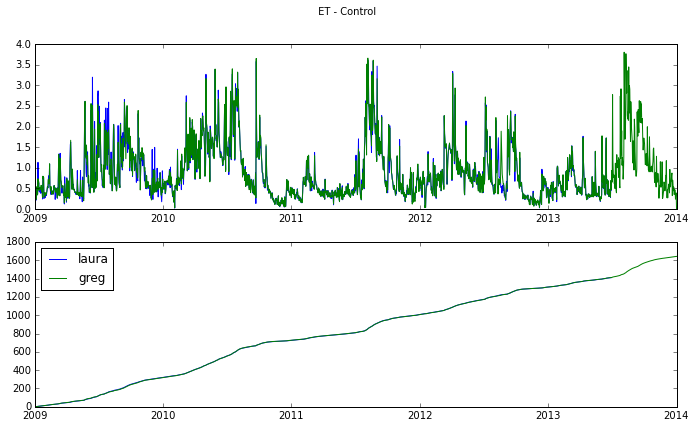

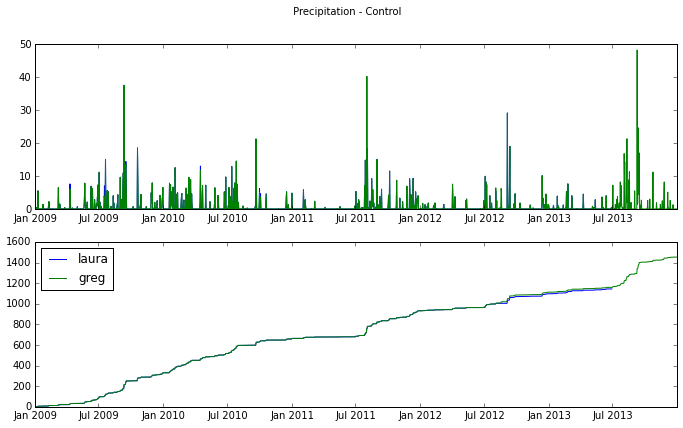

In [13]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_laura.index, pjc_laura.ET)
#plt.plot(pjc_laura.index, pjc_laura.ET_Dayt)
plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_laura.index, pjc_laura.ET.cumsum())
#plt.plot(pjc_laura.index, pjc_laura.ET_Dayt.cumsum())
plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' ET - Control')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_laura.index, pjc_laura.PRECIP)
plt.plot(d.Mpj.index, d.Mpj.P_F)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_laura.index, pjc_laura.PRECIP.cumsum())
plt.plot(d.Mpj.index, d.Mpj.P_F.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Control')
plt.show()

## Plot comparisons for girdle

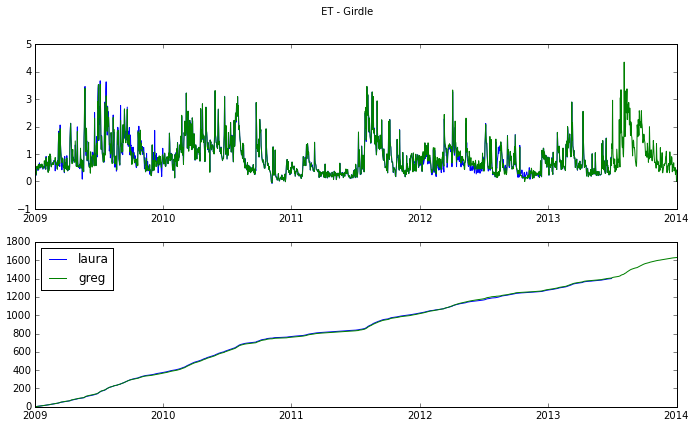

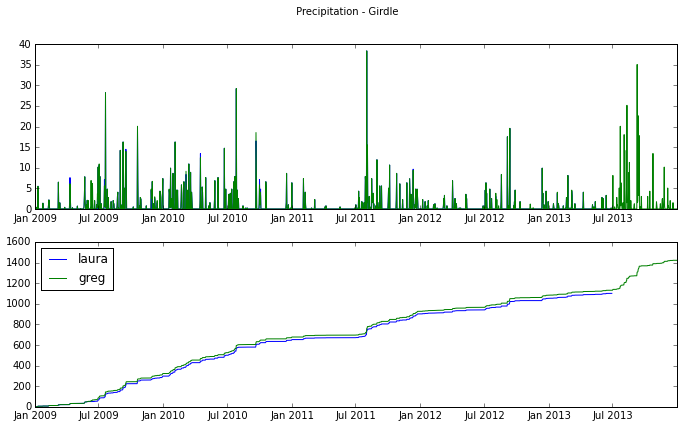

In [14]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_laura.index, pjg_laura.ET)
#plt.plot(pjg_laura.index, pjg_laura.ET_Dayt)
plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_laura.index, pjg_laura.ET.cumsum())
#plt.plot(pjg_laura.index, pjg_laura.ET_Dayt.cumsum())
plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' ET - Girdle')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_laura.index, pjg_laura.PRECIP)
plt.plot(d.Mpg.index, d.Mpg.P_F)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_laura.index, pjg_laura.PRECIP.cumsum())
plt.plot(d.Mpg.index, d.Mpg.P_F.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Girdle')
plt.show()